In [1]:
from scipy.io import loadmat, savemat
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
import tensorflow as tf
import time
print('Tensorflow version', tf.__version__)

%matplotlib inline
matplotlib.style.use("ggplot")

Tensorflow version 1.1.0


<ol>
<li><a href="#Loading-and-Formatting-Data">Loading and Formatting Data</a></li>
<li><a href="#Defining-Helper-Functions">Defining Helper Functions</a></li>
<li><a href="#Test-Model">Test Model</a></li>
</ol>

# Loading and Formatting Data

In [2]:
synth_data = loadmat('./fabricated_mnist_data/data_and_labels.mat')
all_x = synth_data['data']
all_y = synth_data['labels']
print("X shape", all_x.shape)
print("Y 'shape'", all_y.shape)
print("Y first example shape", all_y[0, 0].shape)
print("Y last example shape", all_y[0, -1].shape)

X shape (23330, 28, 140)
Y 'shape' (1, 23330)
Y first example shape (1, 10)
Y last example shape (5, 10)


Reshape y by padding < 5 length labels, and getting the length of the labels

In [3]:
all_y = all_y.reshape(-1)
all_y_lens = np.array([len(y_ex) for y_ex in all_y])
def pad(y_ex):  # padding with "no char" encodings
    toreturn = np.zeros((5, 11))
    toreturn[:len(y_ex), :-1] = y_ex
    toreturn[len(y_ex):, -1] = 1
    return toreturn
pad(np.arange(10*2).reshape(2, 10))


array([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,   0.],
       [ 10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]])

In [4]:
all_y = np.array([pad(y_ex) for y_ex in all_y])
all_y.shape

(23330, 5, 11)

Define train-test-validation split and reshape the data to explicitly have channel size 1

In [5]:
all_x.shape

(23330, 28, 140)

In [6]:
np.random.seed(999)
idx = np.arange(len(all_x))
np.random.shuffle(idx)
temp = len(all_x)//5

train_idx = idx[:(temp*3)]
valid_idx = idx[(temp*3):(temp*4)]
test_idx = idx[(temp*4):]

train_x = all_x[train_idx].reshape(-1, 28, 140, 1)
train_y = all_y[train_idx]

valid_x = all_x[valid_idx].reshape(-1, 28, 140, 1)
valid_y = all_y[valid_idx]

test_x = all_x[test_idx].reshape(-1, 28, 140, 1)
test_y = all_y[test_idx]

In [7]:
all_y.shape

(23330, 5, 11)

# Defining Helper Functions

In [8]:
def get_pred(y):
    digits = np.argmax(y, axis=-1)
    
    return [''.join([str(x).replace('10', '_') for x in dig]) for dig in digits]
digs = [
    [
        [0, 1]+[0]*9,
        [0, 0.2, 0.8] + [0]*8,
        [0, 1]+[0]*9,
        [0, 0.2, 0.8] + [0]*8,
        [0]*10 + [1]
    ]
]
get_pred(digs)

['1212_']

In [9]:
def c(a):
    if isinstance(a, tf.Tensor):
        return a.eval()
    else:
        return a

In [10]:
def accuracy(y_true, y_pred):
    y_true = c(y_true)
    y_pred = c(y_pred)
    actual = np.array(get_pred(y_true))
    pred = np.array(get_pred(y_pred))
    return np.mean(actual == pred)

# Test Model

In [11]:
lr = 0.001
simplest_graph =  tf.Graph()

In [56]:
with simplest_graph.as_default(): 
    tf_x = tf.placeholder(tf.float32, (None, all_x.shape[1], all_x.shape[2], 1))
    tf_y = tf.placeholder(tf.float32, (None, all_y.shape[1], all_y.shape[2]))
    
    # (N, 28, 140, 1)
    conv1_w = tf.Variable(tf.truncated_normal(shape=[5, 5, 1, 5], stddev=0.1, seed=54), name="conv1_w")
    conv1_b = tf.Variable(tf.zeros(shape=[5]), name="conv1_b")
    
    # (N, 28, 140, 5)
    conv2_w = tf.Variable(tf.truncated_normal(shape=[1, 1, 5, 5], stddev=0.1, seed=741), name="conv2_w")
    conv2_b = tf.Variable(tf.zeros(shape=[5]), name="conv2_b")
    
    # (N, 28, 140, 5)
    
    
    # (N, 15, 71, 5)
    conv4_w = tf.Variable(tf.truncated_normal(shape=[3, 3, 5, 15], stddev=0.1, seed=11), name="conv4_w")
    conv4_b = tf.Variable(tf.zeros(shape=[15]), name="conv4_b")
    
    # (N, 15, 71, 15)
    conv5_w = tf.Variable(tf.truncated_normal(shape=[1, 1, 15, 7], stddev=0.1, seed=11), name="conv5_w")
    conv5_b = tf.Variable(tf.zeros(shape=[7]), name="conv5_b")
    
    # (N, 15, 71, 7)
        
    # (N, 8, 36, 7)
    conv7_w = tf.Variable(tf.truncated_normal(shape=[2, 4, 7, 4], stddev=0.1, seed=11), name="conv7_w")
    conv7_b = tf.Variable(tf.zeros(shape=[4]), name="conv7_b")
    
    
    # (N, 8, 36, 4) -> (N, 1410)
    dens8_w = tf.Variable(tf.truncated_normal(shape=[980, 400], stddev=0.1, seed=65), name="dens8_w")
    dens8_b = tf.Variable(tf.zeros(shape=[400]), name="dens8_b")
    
    # (N, 200)
    dig_w = tf.Variable(tf.truncated_normal(shape=[400, 5*11], stddev=0.1, seed=87), name="dig_w")
    dig_b = tf.Variable(tf.zeros(shape=[5*11]), name="dig_b")

In [57]:
def model(x):
    o1 = tf.nn.relu(tf.nn.conv2d(x, conv1_w, [1, 1, 1, 1], 'SAME') + conv1_b)
    o2 = tf.nn.relu(tf.nn.conv2d(o1, conv2_w, [1, 1, 1, 1], 'SAME') + conv2_b)
    o3 = tf.nn.max_pool(o2, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    o4 = tf.nn.relu(tf.nn.conv2d(o3, conv4_w, [1, 1, 1, 1], 'SAME') + conv4_b)
    o5 = tf.nn.relu(tf.nn.conv2d(o4, conv5_w, [1, 1, 1, 1], 'SAME') + conv5_b)
    o6 = tf.nn.max_pool(o5, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    o7 = tf.nn.relu(tf.nn.conv2d(o6, conv7_w, [1, 1, 1, 1], 'SAME') + conv7_b)
    o7resh = tf.reshape(o7, [-1, 980])
    o8 = tf.nn.relu(tf.matmul(o7resh, dens8_w) + dens8_b)
    odig = tf.nn.relu(tf.matmul(o8, dig_w) + dig_b)
    return odig

In [58]:
with simplest_graph.as_default():
    
    tf_diglogit = model(tf_x)
    tf_diglogit = tf.reshape(tf_diglogit, shape=[-1, 5, 11])
    tf_digproba = tf.nn.softmax(tf_diglogit, dim=-1)
    print(tf_diglogit.get_shape())
    tf_dig_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_y, logits=tf_diglogit))
    
    optimizer = tf.train.AdamOptimizer(lr)
    updater = optimizer.minimize(tf_dig_loss)

(?, 5, 11)


In [59]:
n_epochs = 30
batch_size = 20
steps_per_epoch = 2500
compare_every = 30
t_losses, v_losses = [], []
t_acc, v_acc = [], []

In [60]:
def capture_performance():
    global session
    global batch_size
    global batch_idx
    global train_x
    global train_y
    global valid_x
    global valid_y
    global t_acc
    global v_acc
#     print('Saving performance')
    
    train_loss, train_proba = session.run([tf_dig_loss, tf_digproba], 
                                                                                   feed_dict={
        tf_x: train_x[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)], 
        tf_y: train_y[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)], 
    })
    
    valid_loss, valid_proba = session.run([tf_dig_loss, tf_digproba], 
                                                                                   feed_dict={
        tf_x: valid_x, tf_y: valid_y})
    
    t_losses.append(np.mean(train_loss))
    t_acc.append(accuracy(train_y[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)], 
                          train_proba,))
    v_losses.append(np.mean(valid_loss))
    v_acc.append(accuracy(valid_y, valid_proba))                      

In [61]:
session = tf.InteractiveSession(graph=simplest_graph)
init = tf.global_variables_initializer()
init.run()
np.random.seed(123456)
for ep in range(n_epochs):
    idx = np.arange(len(train_x))
    np.random.shuffle(idx) # shuffling the data each epoch
    train_x = train_x[idx]
    train_y = train_y[idx]
    ep_dig_losses = []
    for batch_idx in range(min(len(train_x)//batch_size, steps_per_epoch)):
        batch_x = train_x[batch_size*batch_idx:(batch_size*(batch_idx+1))].reshape(-1, 28, 140, 1)
        batch_y = train_y[batch_size*batch_idx:(batch_size*(batch_idx+1))]
        _, batch_dig_loss = session.run([updater, tf_dig_loss], 
                                                         feed_dict={tf_x: batch_x, tf_y: batch_y})
        ep_dig_losses.append(np.mean(batch_dig_loss))
        if (batch_idx) % compare_every == 0:
            capture_performance()        
        
    v_loss, v_proba = session.run([tf_dig_loss, tf_digproba], 
                                                                {tf_x: valid_x, tf_y: valid_y})
    print("Epoch {}".format(ep))
#     print(v_acc)
    print("Validation accuracy {:<2.3%}".format(accuracy(valid_y, v_dig_proba)))
    
    print("Mean batch dig loss {:<2.3f}".format(np.mean(ep_dig_losses)))
    print("Valid dig loss {:<2.3f}".format(np.mean(v_loss)))
    
    plt.plot(t_acc, label='Train Accuracy')
    plt.plot(v_acc, label='Validation Accuracy')
    plt.ylim((0, 1))
    plt.legend(loc='best')
    plt.show()

C:\Users\Ian\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


KeyboardInterrupt: 

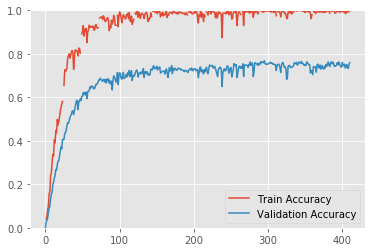

In [213]:
plt.plot(t_acc, label='Train Accuracy')
plt.plot(v_acc, label='Validation Accuracy')
plt.ylim((0, 1))
plt.legend()
plt.show()

# Keras model version

In [12]:
import keras
keras.__version__

Using TensorFlow backend.


'2.0.2'

In [91]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Reshape, Dropout, Masking, Activation
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.activations import softmax
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import TensorBoard

In [80]:
def capture_performance2():
    global batch_size
    global batch_idx
    global train_x
    global train_y
    global valid_x
    global valid_y
    global t_acc
    global v_acc
#     print('Saving performance')
    try:
        train_dig_proba = model.predict(train_x[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)])
        t_acc.append(accuracy(train_y[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)], 
                      train_dig_proba))
    except:
        t_acc.append(np.nan)
    
    valid_dig_proba = model.predict(valid_x)
    v_acc.append(accuracy(valid_y, valid_dig_proba))                      
    print('capture_performance2(): valid accuracy {}'.format(v_acc[-1]))

In [39]:
in0 = Input(shape=[all_x.shape[1], all_x.shape[2], 1], name='X')
conv1 = Conv2D(5, (3, 3), strides=(1, 1), padding='same', activation='relu')(in0)
conv2 = Conv2D(5, (1, 1), strides=(1, 1), padding='same', activation='relu')(conv1)
max3 = MaxPooling2D((2, 2), (2, 2), padding='same')(conv2)
conv4 = Conv2D(15, (3, 3), strides=(1, 1), padding='same', activation='relu')(max3)
conv5 = Conv2D(30, (1, 1), strides=(1, 1), padding='same', activation='relu')(conv4)
max6 = MaxPooling2D((2, 2), (2, 2), padding='same')(conv5)
conv7 = Conv2D(15, (3, 3), strides=(1, 1), padding='same', activation='relu')(max6)
max8 = MaxPooling2D((2, 2), (2, 2), padding='same')(conv7)
resh8 = Reshape([-1])(max8)
dens9 = Dense(400, activation='relu', kernel_regularizer=l2(0.003))(resh8)
dens9 = Dropout(0.7)(dens9)

dig_10 = Dense(5*11, activation='linear', kernel_regularizer=l2(0.001))(dens9)
resh10 = Reshape([5, 11])(dig_10)
softmax10 = Activation('softmax')(resh10)

model = Model(in0, outputs=[softmax10])
opt = Adam(0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [40]:
n_epochs = 30
batch_size = 30
steps_per_epoch = 250000
compare_every = 60
t_dig_losses, v_dig_losses = [], []
t_acc, v_acc = [], []

Epoch 0
Validation accuracy 14.616%
Mean batch dig loss 2.291
Valid dig loss 1.509


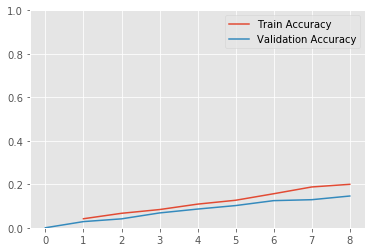

Epoch 1
Validation accuracy 32.512%
Mean batch dig loss 1.384
Valid dig loss 1.021


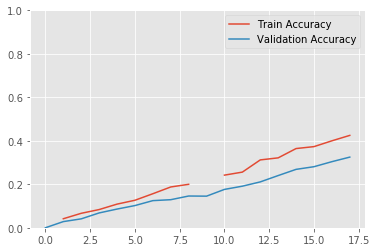

Epoch 2
Validation accuracy 50.557%
Mean batch dig loss 1.120
Valid dig loss 0.797


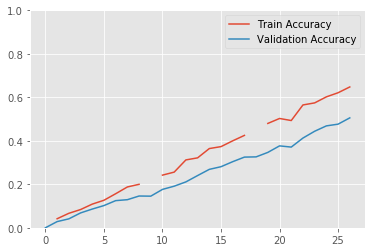

Epoch 3
Validation accuracy 61.187%
Mean batch dig loss 0.985
Valid dig loss 0.669


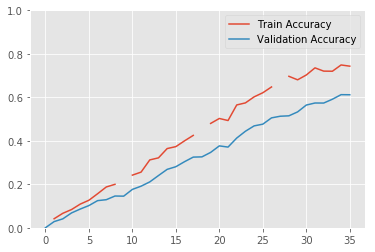

Epoch 4
Validation accuracy 66.845%
Mean batch dig loss 0.898
Valid dig loss 0.606


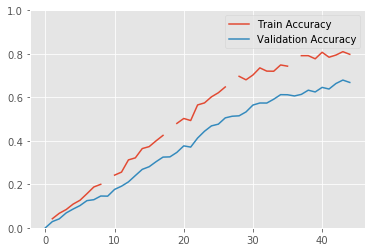

Epoch 5
Validation accuracy 71.346%
Mean batch dig loss 0.843
Valid dig loss 0.566


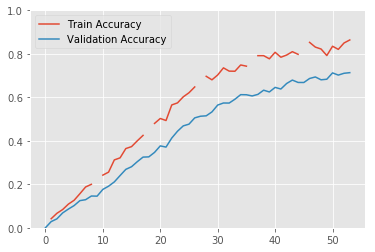

Epoch 6
Validation accuracy 71.967%
Mean batch dig loss 0.798
Valid dig loss 0.549


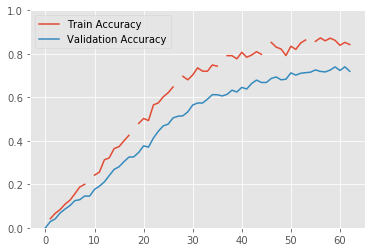

Epoch 7
Validation accuracy 75.654%
Mean batch dig loss 0.767
Valid dig loss 0.521


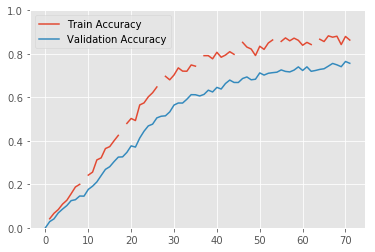

Epoch 8
Validation accuracy 76.940%
Mean batch dig loss 0.744
Valid dig loss 0.497


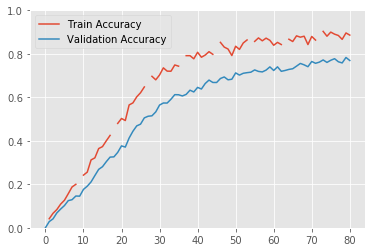

Epoch 9
Validation accuracy 76.725%
Mean batch dig loss 0.729
Valid dig loss 0.488


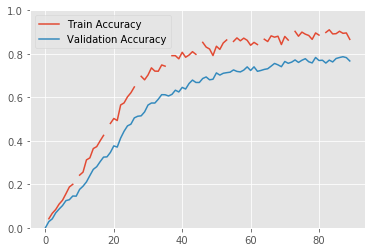

Epoch 10
Validation accuracy 79.597%
Mean batch dig loss 0.708
Valid dig loss 0.465


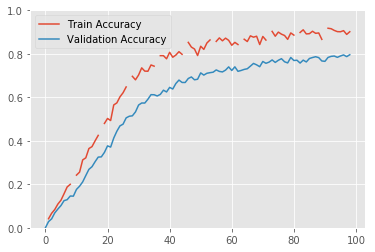

Epoch 11
Validation accuracy 80.754%
Mean batch dig loss 0.698
Valid dig loss 0.459


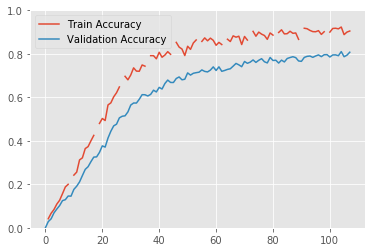

Epoch 12
Validation accuracy 81.783%
Mean batch dig loss 0.685
Valid dig loss 0.451


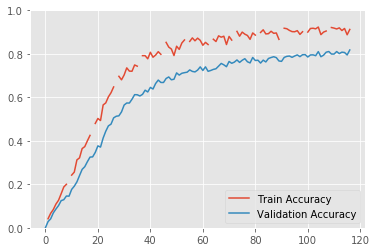

Epoch 13
Validation accuracy 81.097%
Mean batch dig loss 0.671
Valid dig loss 0.446


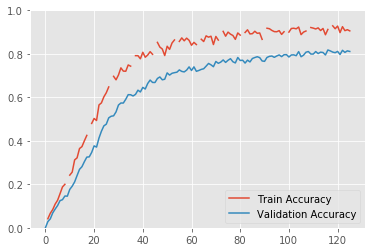

Epoch 14
Validation accuracy 81.912%
Mean batch dig loss 0.663
Valid dig loss 0.437


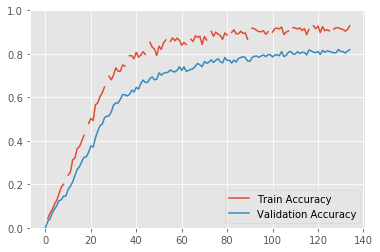

Epoch 15
Validation accuracy 79.876%
Mean batch dig loss 0.658
Valid dig loss 0.451


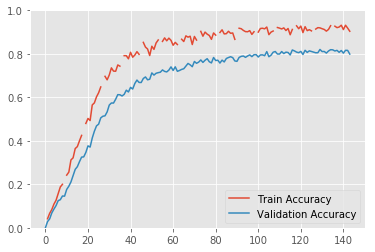

Epoch 16
Validation accuracy 81.805%
Mean batch dig loss 0.653
Valid dig loss 0.432


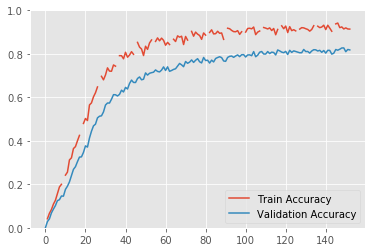

Epoch 17
Validation accuracy 82.855%
Mean batch dig loss 0.646
Valid dig loss 0.432


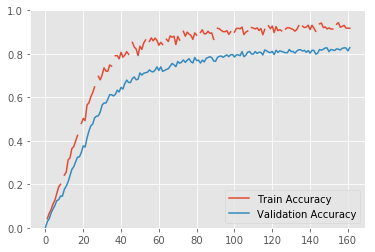

Epoch 18
Validation accuracy 83.476%
Mean batch dig loss 0.641
Valid dig loss 0.423


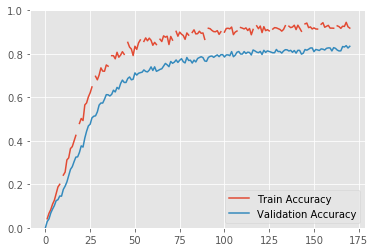

Epoch 19
Validation accuracy 82.576%
Mean batch dig loss 0.630
Valid dig loss 0.429


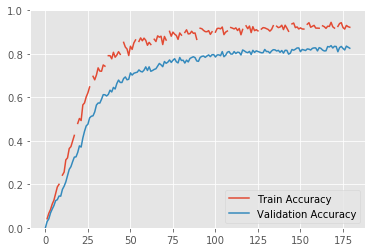

Epoch 20
Validation accuracy 82.083%
Mean batch dig loss 0.631
Valid dig loss 0.427


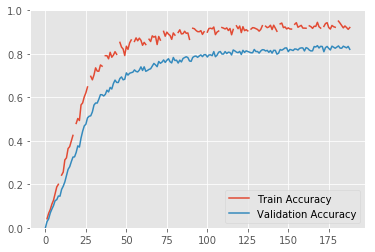

Epoch 21
Validation accuracy 84.205%
Mean batch dig loss 0.626
Valid dig loss 0.411


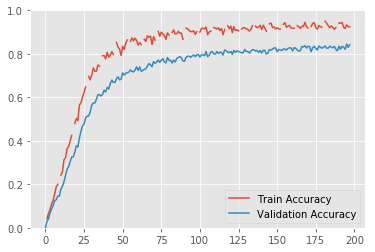

Epoch 22
Validation accuracy 82.533%
Mean batch dig loss 0.625
Valid dig loss 0.429


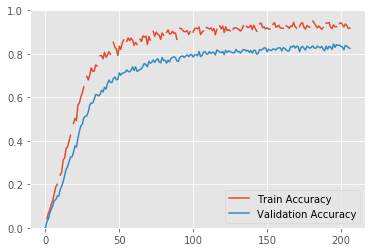

Epoch 23
Validation accuracy 82.147%
Mean batch dig loss 0.618
Valid dig loss 0.429


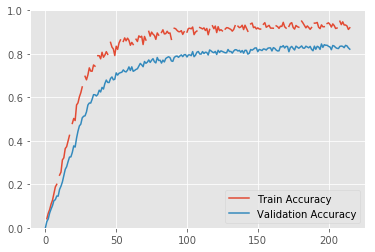

Epoch 24
Validation accuracy 83.155%
Mean batch dig loss 0.616
Valid dig loss 0.425


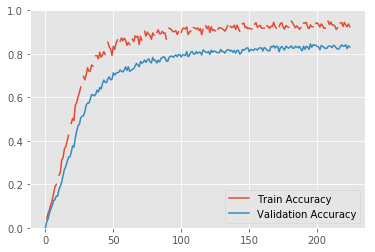

Epoch 25
Validation accuracy 82.812%
Mean batch dig loss 0.615
Valid dig loss 0.413


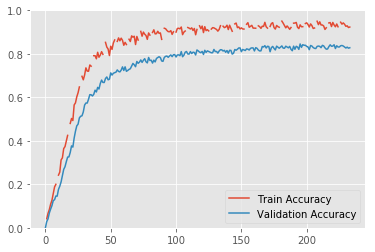

Epoch 26
Validation accuracy 84.505%
Mean batch dig loss 0.606
Valid dig loss 0.403


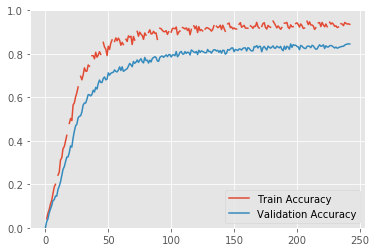

Epoch 27
Validation accuracy 84.398%
Mean batch dig loss 0.602
Valid dig loss 0.407


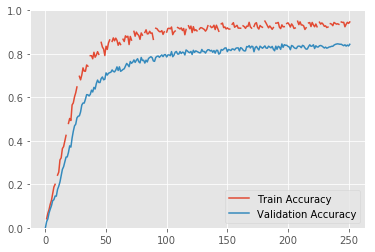

Epoch 28
Validation accuracy 84.033%
Mean batch dig loss 0.600
Valid dig loss 0.407


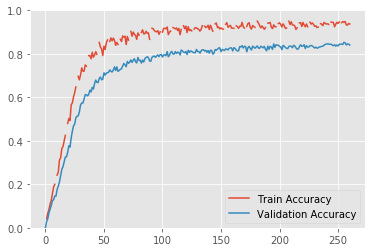

Epoch 29
Validation accuracy 83.112%
Mean batch dig loss 0.598
Valid dig loss 0.414


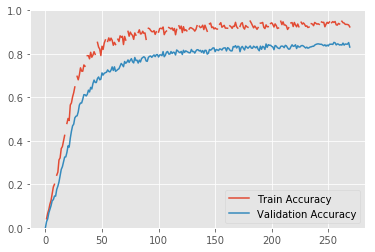

In [41]:
np.random.seed(123456)
for ep in range(n_epochs):
    idx = np.arange(len(train_x))
    np.random.shuffle(idx) # shuffling the data each epoch
    train_x = train_x[idx]
    train_y = train_y[idx]
    ep_dig_losses = []
    for batch_idx in range(min(len(train_x)//batch_size, steps_per_epoch)):
        batch_x = train_x[batch_size*batch_idx:(batch_size*(batch_idx+1))].reshape(-1, 28, 140, 1)
        batch_y = train_y[batch_size*batch_idx:(batch_size*(batch_idx+1))]
        total_loss = model.train_on_batch(batch_x, batch_y)
        
        ep_dig_losses.append(total_loss)
        if (batch_idx) % compare_every == 0:
            capture_performance2()
            
    capture_performance2()
                   
    v_dig_proba = model.predict(valid_x)
    v_dig_loss = model.evaluate(valid_x, valid_y, verbose=0)
    print("Epoch {}".format(ep))
#     print(v_acc)
    print("Validation accuracy {:<2.3%}".format(accuracy(valid_y, v_dig_proba)))
    
    print("Mean batch dig loss {:<2.3f}".format(np.mean(ep_dig_losses)))
    print("Valid dig loss {:<2.3f}".format(np.mean(v_dig_loss)))
    
    plt.plot(t_acc, label='Train Accuracy')
    plt.plot(v_acc, label='Validation Accuracy')
    plt.ylim((0, 1))
    plt.legend()
    plt.show()

In [102]:
in0 = Input(shape=[all_x.shape[1], all_x.shape[2], 1], name='X')
conv1 = Conv2D(5, (3, 3), strides=(1, 1), padding='same', activation='relu')(in0)
conv2 = Conv2D(25, (3, 3), strides=(1, 1), padding='same', activation='relu')(conv1)
conv2 = Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu')(conv2)
max3 = MaxPooling2D((2, 2), (2, 2), padding='same')(conv2)
conv4 = Conv2D(100, (3, 3), strides=(1, 1), padding='same', activation='relu')(max3)
conv5 = Conv2D(200, (5, 5), strides=(1, 1), padding='same', activation='relu')(conv4)
max6 = MaxPooling2D((2, 2), (2, 2), padding='same')(conv5)
conv7 = Conv2D(200, (3, 3), strides=(1, 1), padding='same', activation='relu')(max6)
conv8 = Conv2D(200, (1, 1), strides=(1, 1), padding='same', activation='relu')(conv7)
max9 = MaxPooling2D((2, 2), (2, 2), padding='same')(conv8)
conv10 = Conv2D(100, (5, 5), strides=(1, 1), padding='same', activation='relu')(max9)
conv11 = Conv2D(50, (1, 1), strides=(1, 1), padding='same', activation='relu')(conv10)
max12 = MaxPooling2D((2, 2), (2, 2), padding='same')(conv11)

resh12 = Reshape([-1])(max12)
dens13 = Dense(800, activation='relu', kernel_regularizer=l2(0.0001))(resh12)
dens13 = Dropout(0.4)(dens13)
dens14 = Dense(400, activation='relu', kernel_regularizer=l2(0.0001))(dens13)
dens14 = Dropout(0.5)(dens14)

dig_15 = Dense(5*11, activation='linear', kernel_regularizer=l2(0.0001))(dens14)
resh15 = Reshape([5, 11])(dig_15)
softmax15 = Activation('softmax')(resh15)

model = Model(in0, outputs=[softmax15])
opt = Adam(0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [103]:
n_epochs = 30
batch_size = 15
steps_per_epoch = 250000
compare_every = 100
t_dig_losses, v_dig_losses = [], []
t_acc, v_acc = [], []

capture_performance2(): valid accuracy 0.0
capture_performance2(): valid accuracy 0.023789112730390055
capture_performance2(): valid accuracy 0.024217745392198887
capture_performance2(): valid accuracy 0.04586369481354479
capture_performance2(): valid accuracy 0.08786969567081011
capture_performance2(): valid accuracy 0.1795970852978997
capture_performance2(): valid accuracy 0.2741105872267467
capture_performance2(): valid accuracy 0.3819117016716674
capture_performance2(): valid accuracy 0.46870981568795544
capture_performance2(): valid accuracy 0.5357908272610373
3e+01
capture_performance2(): valid accuracy 0.5445777968281184
Epoch 0
Validation accuracy 54.458%
Mean batch dig loss 1.328
Valid dig loss 0.584


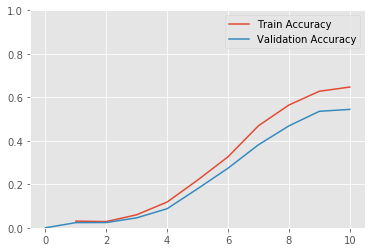

capture_performance2(): valid accuracy 0.5600085726532362
capture_performance2(): valid accuracy 0.652378911273039
capture_performance2(): valid accuracy 0.7085297899699957
capture_performance2(): valid accuracy 0.7522503214744963
capture_performance2(): valid accuracy 0.7511787398199743
capture_performance2(): valid accuracy 0.8111873124732104
capture_performance2(): valid accuracy 0.8291898842691813
capture_performance2(): valid accuracy 0.8634804972138876
capture_performance2(): valid accuracy 0.8591941705957994
capture_performance2(): valid accuracy 0.8769824260608658
3e+01
capture_performance2(): valid accuracy 0.8696956708101158
Epoch 1
Validation accuracy 86.970%
Mean batch dig loss 0.526
Valid dig loss 0.251


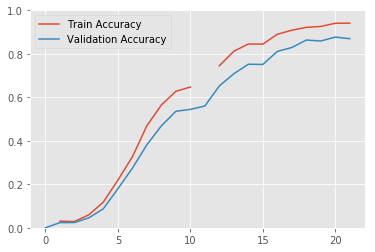

capture_performance2(): valid accuracy 0.8748392627518217
capture_performance2(): valid accuracy 0.8776253750535791
capture_performance2(): valid accuracy 0.8921988855550793
capture_performance2(): valid accuracy 0.8870552936133733


In [ ]:
np.random.seed(123456)
t1 = time.time()
for ep in range(n_epochs):
    s1 = time.time()
    idx = np.arange(len(train_x))
    np.random.shuffle(idx) # shuffling the data each epoch
    train_x = train_x[idx]
    train_y = train_y[idx]
    ep_dig_losses = []
    for batch_idx in range(min(len(train_x)//batch_size, steps_per_epoch)):
        batch_x = train_x[batch_size*batch_idx:(batch_size*(batch_idx+1))].reshape(-1, 28, 140, 1)
        batch_y = train_y[batch_size*batch_idx:(batch_size*(batch_idx+1))]
        total_loss = model.train_on_batch(batch_x, batch_y)
        
        ep_dig_losses.append(total_loss)
        if (batch_idx) % compare_every == 0:
            capture_performance2()
    print('{:4.2}'.format((time.time() - s1)/60))
    capture_performance2()
                   
    v_dig_proba = model.predict(valid_x)
    v_dig_loss = model.evaluate(valid_x, valid_y, verbose=0)
    print("Epoch {}".format(ep))
#     print(v_acc)
    print("Validation accuracy {:<2.3%}".format(accuracy(valid_y, v_dig_proba)))
    
    print("Mean batch dig loss {:<2.3f}".format(np.mean(ep_dig_losses)))
    print("Valid dig loss {:<2.3f}".format(np.mean(v_dig_loss)))
    
    plt.plot(t_acc, label='Train Accuracy')
    plt.plot(v_acc, label='Validation Accuracy')
    plt.ylim((0, 1))
    plt.legend()
    plt.show()
print('{:4.2}'.format((time.time() - t1)/60))